In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from itertools import product

In [2]:
# Data loading
def load_cifar10():
    transform = transforms.Compose([transforms.ToTensor()])
    cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    target_classes = [9, 1]
    mask = [label in target_classes for _, label in cifar10]
    cifar10.data = cifar10.data[mask]
    cifar10.targets = [0 if label == 9 else 1 for label in cifar10.targets if label in target_classes]
    return cifar10

# Data preprocessing
def preprocess_data(cifar10):
    # Flatten the data for normalization
    flattened_data = cifar10.data.reshape(cifar10.data.shape[0], -1).astype(np.float32)
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(flattened_data)

    # Split into train/val/test
    train_size = int(0.7 * len(cifar10))
    val_size = int(0.15 * len(cifar10))
    test_size = len(cifar10) - train_size - val_size
    train_data, val_data, test_data = random_split(cifar10, [train_size, val_size, test_size])
    
    return train_data, val_data, test_data

In [3]:
# Define the CNN Model
class CNN(nn.Module):
    def __init__(self, num_filters, dropout_rate):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(num_filters * 4 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
# Hyperparameter tuning
def hyperparameter_tuning(train_data, val_data, param_grid):
    best_params = None
    best_val_accuracy = 0
    results = []

    for lr, batch_size, num_filters, dropout_rate in product(
        param_grid['lr'], param_grid['batch_size'], param_grid['num_filters'], param_grid['dropout_rate']
    ):
        print(f"Trial: lr={lr}, batch_size={batch_size}, num_filters={num_filters}, dropout_rate={dropout_rate}")
        
        # Create DataLoaders
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and loss
        model = CNN(num_filters=num_filters, dropout_rate=dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Train the model over 10 epochs for hyperparameter tuning
        for epoch in range(10):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validate the model
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Save the results
        results.append((lr, batch_size, num_filters, dropout_rate, val_accuracy))
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'lr': lr,
                'batch_size': batch_size,
                'num_filters': num_filters,
                'dropout_rate': dropout_rate
            }

    print(f"Best Parameters: {best_params}")
    return best_params, results

In [5]:
# Final training and testing
def final_training_and_testing(train_data, test_data, best_params):
    train_loader = DataLoader(train_data, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

    # Initialize model, optimizer, and loss
    model = CNN(num_filters=best_params['num_filters'], dropout_rate=best_params['dropout_rate'])
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    criterion = nn.CrossEntropyLoss()

    training_losses = []
    test_losses = []
    training_accuracies = []
    test_accuracies = []
    epochs = 50

    all_test_labels = []
    all_test_probs = []
    all_test_preds = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = correct_train / total_train
        training_losses.append(epoch_loss / len(train_loader))
        training_accuracies.append(train_accuracy)

        # Testing
        model.eval()
        epoch_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()
                probs = nn.Softmax(dim=1)(outputs)[:, 1]
                _, predicted = torch.max(outputs, 1)
                all_test_probs.extend(probs.numpy())
                all_test_labels.extend(labels.numpy())
                all_test_preds.extend(predicted.numpy())
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_accuracy = correct_test / total_test
        test_losses.append(epoch_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Final Metrics
    accuracy = accuracy_score(all_test_labels, all_test_preds)
    fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
    auroc = roc_auc_score(all_test_labels, all_test_probs)
    conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Training and Test Accuracy vs Epochs
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy vs Epochs')
    plt.legend()
    plt.show()

    # Training and Test Accuracy vs Batch Size
    train_acc_per_batch = []
    test_acc_per_batch = []

    train_acc_per_lr = []
    test_acc_per_lr = []

    for lr in param_grid['lr']:
        # Update optimizer with the current learning rate
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Retrain model for each learning rate
        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # Evaluate Training Accuracy
        model.eval()
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            with torch.no_grad():
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
        train_acc_per_lr.append(correct_train / total_train)

        # Evaluate Test Accuracy
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            with torch.no_grad():
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_acc_per_lr.append(correct_test / total_test)

    # Plot Training and Test Accuracy vs Learning Rate
    plt.figure(figsize=(8, 6))
    plt.plot(param_grid['lr'], train_acc_per_lr, label='Training Accuracy', marker='o')
    plt.plot(param_grid['lr'], test_acc_per_lr, label='Test Accuracy', marker='x')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy vs Learning Rate')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"Final AUROC: {roc_auc_score(all_test_labels, all_test_probs):.4f}")
    print(f"Per-Class Accuracy: {dict(enumerate(per_class_accuracy))}")

Files already downloaded and verified
Trial: lr=0.001, batch_size=8, num_filters=8, dropout_rate=0.2
Validation Accuracy: 0.8440
Trial: lr=0.001, batch_size=8, num_filters=8, dropout_rate=0.5
Validation Accuracy: 0.8807
Trial: lr=0.001, batch_size=8, num_filters=16, dropout_rate=0.2
Validation Accuracy: 0.8793
Trial: lr=0.001, batch_size=8, num_filters=16, dropout_rate=0.5
Validation Accuracy: 0.8940
Trial: lr=0.001, batch_size=8, num_filters=32, dropout_rate=0.2
Validation Accuracy: 0.8973
Trial: lr=0.001, batch_size=8, num_filters=32, dropout_rate=0.5
Validation Accuracy: 0.8733
Trial: lr=0.001, batch_size=16, num_filters=8, dropout_rate=0.2
Validation Accuracy: 0.8880
Trial: lr=0.001, batch_size=16, num_filters=8, dropout_rate=0.5
Validation Accuracy: 0.8607
Trial: lr=0.001, batch_size=16, num_filters=16, dropout_rate=0.2
Validation Accuracy: 0.9020
Trial: lr=0.001, batch_size=16, num_filters=16, dropout_rate=0.5
Validation Accuracy: 0.8773
Trial: lr=0.001, batch_size=16, num_filter

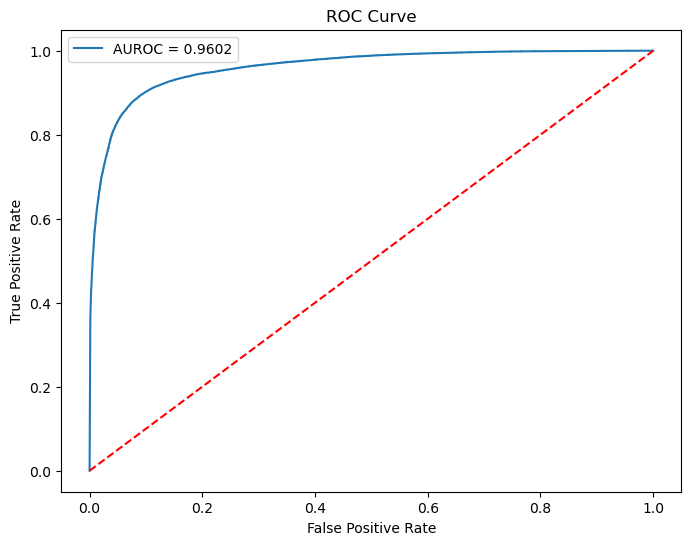

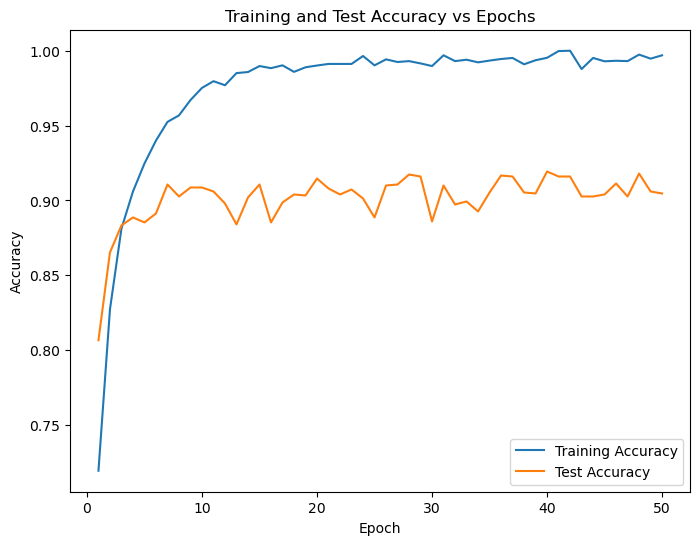

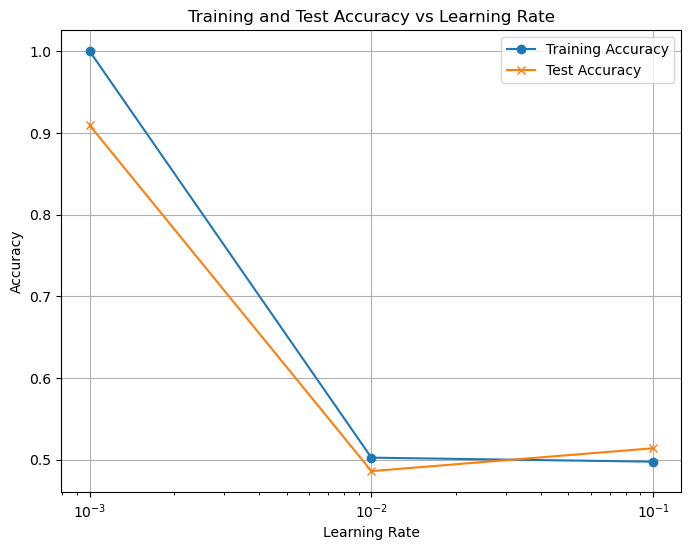

Final Test Accuracy: 0.9012
Final AUROC: 0.9602
Per-Class Accuracy: {0: 0.9147050754458161, 1: 0.8883527885862517}


In [6]:
# Pipeline Execution
cifar10 = load_cifar10()
train_data, val_data, test_data = preprocess_data(cifar10)
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [8, 16, 32, 64],
    'num_filters': [8, 16, 32],
    'dropout_rate': [0.2, 0.5]
}
best_params, results = hyperparameter_tuning(train_data, val_data, param_grid)
final_training_and_testing(train_data + val_data, test_data, best_params)

In [7]:
per_class_accuracy = {0: 0.9147050754458161, 1: 0.8883527885862517}
index_to_class_label = {0: -1, 1: 1}
mapped_per_class_accuracy = {index_to_class_label[k]: v for k, v in per_class_accuracy.items()}
print("Mapped Per-Class Accuracy:", mapped_per_class_accuracy)

Mapped Per-Class Accuracy: {-1: 0.9147050754458161, 1: 0.8883527885862517}
